In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import pickle
import spliland
import importlib
import random
import fclParse
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

Welcome to JupyROOT 6.18/04


In [2]:
directory = './template_data_v2/set_2/'
n_epochs = 20

In [3]:
tf.config.run_functions_eagerly(True)

## Intro

The purpose of this notebook is to make a second attempt at a neural network, following along with what was described in the paper "Deep Learning Based Pulse Shape Analysis for GERDA" by Philipp Holl in 2017. This algorithm consists of an autoencoder, decoder, and then classifier.

I am also following this guide: https://keras.io/examples/timeseries/timeseries_anomaly_detection/ for the implementation of the layers described in the paper into python

### Prep the data

In [4]:
n_points = 4500

with open(directory + 'x.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_train = []
    x_test = []
    for x in biggestX[:n_points]:
        x_train.append(x)
    for x in biggestX[n_points:n_points+500]:
        x_test.append(x)
    xFile.close()

with open(directory + 'y.data', 'rb') as yFile:
    biggestY = pickle.load(yFile)
    y_train = biggestY[:n_points]
    y_test = biggestY[n_points:n_points+500]
    yFile.close()
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
X_train = np.reshape(x_train, (n_points, 21816, 1))
Y_train = np.reshape(y_train, (n_points, 1))

In [6]:
X_train.shape

(4500, 21816, 1)

### Classifier

In [7]:
classifier_model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(21816,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu')
])

2021-01-22 13:15:45.761502: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lars/root6/lib
2021-01-22 13:15:45.761533: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-01-22 13:15:45.761553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LarsXPS15): /proc/driver/nvidia/version does not exist
2021-01-22 13:15:45.761917: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-22 13:15:45.773869: I tensorflow/core/platform/profile_utils/cpu_ut

In [8]:
classifier_model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [9]:
print(X_train.shape)
print(Y_train.shape)

(4500, 21816, 1)
(4500, 1)


In [10]:
classifier_history = classifier_model.fit(X_train,
                                          Y_train,
                                          epochs=n_epochs)

/home/lars/miniconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
141/141 [==============================] - 9s 66ms/step - loss: 2.3209 - accuracy: 0.3024
Epoch 2/20
141/141 [==============================] - 8s 54ms/step - loss: 1.8151 - accuracy: 0.3820
Epoch 3/20
141/141 [==============================] - 7s 51ms/step - loss: 1.0033 - accuracy: 0.5473
Epoch 4/20
141/141 [==============================] - 8s 53ms/step - loss: 0.8421 - accuracy: 0.6333
Epoch 5/20
141/141 [==============================] - 7s 51ms/step - loss: 0.7146 - accuracy: 0.7040
Epoch 6/20
141/141 [==============================] - 7s 51ms/step - loss: 0.6672 - accuracy: 0.7418
Epoch 7/20
141/141 [==============================] - 7s 47ms/step - loss: 0.5678 - accuracy: 0.7751
Epoch 8/20
141/141 [==============================] - 7s 48ms/step - loss: 0.4764 - accuracy: 0.8289
Epoch 9/20
141/141 [==============================] - 7s 49ms/step - loss: 0.4233 - accuracy: 0.8418
Epoch 10/20
141/141 [==============================] - 8s 56ms/step - loss: 0.4086 - accura

In [11]:
h_df = pd.DataFrame(classifier_history.history)
h_df.to_csv(directory + 'e{0}.csv'.format(n_epochs))

### Performance Stats

No handles with labels found to put in legend.
No handles with labels found to put in legend.


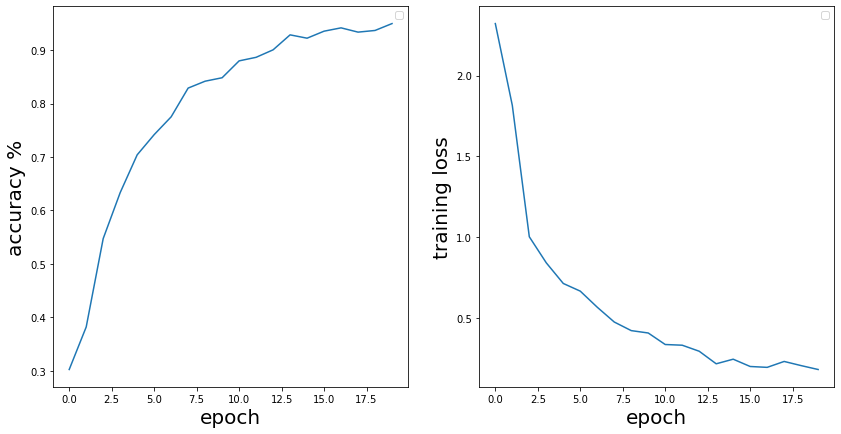

In [12]:
fig, ax = plt.subplots(1,2);
fig.set_size_inches(14,7);

ax[0].plot(classifier_history.history['accuracy'])

ax[0].set_xlabel("epoch", fontsize=20)
ax[0].set_ylabel("accuracy %", fontsize=20)
ax[0].legend()

ax[1].plot(classifier_history.history['loss'])

ax[1].set_xlabel("epoch", fontsize=20)
ax[1].set_ylabel("training loss", fontsize=20)
ax[1].legend()

In [13]:
Y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

matrix = confusion_matrix(y_test, y_pred, normalize='true', labels=[0,1,2,3,4,5,6])

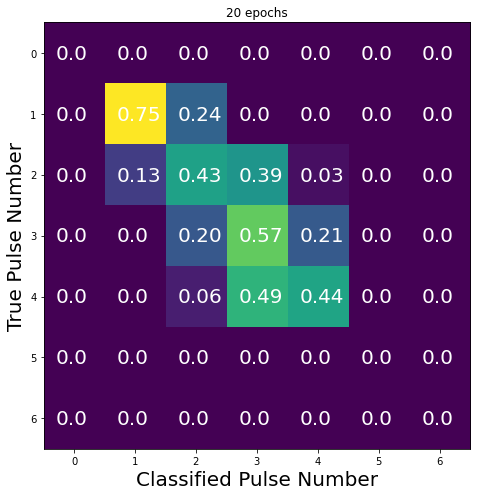

In [14]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)

labels = ['0', '1', '2', '3', '4', '5', '6']

grid = np.array(matrix)
im = ax.imshow(grid)

for k in range (0, len(grid)):
        for l in range (0, len(grid[0])):
            ax.text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color='white')
            
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);

ax.set_ylabel('True Pulse Number', fontsize=20);
ax.set_xlabel('Classified Pulse Number', fontsize=20);
ax.set_title('{0} epochs'.format(n_epochs))

fig.tight_layout()

#ax.set_title("with autoencoder", fontsize=20)
plt.savefig(directory + "e{0}.png".format(n_epochs))

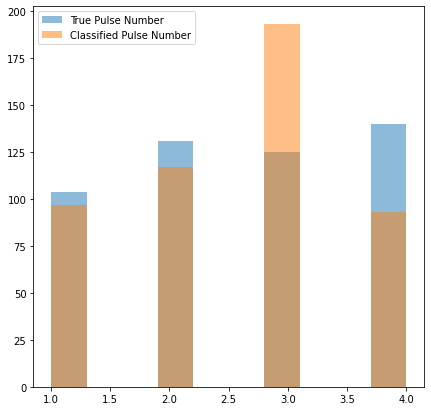

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 7)

ax.hist(y_test, alpha=0.5, label='True Pulse Number')
ax.hist(y_pred, alpha=0.5, label='Classified Pulse Number')
ax.legend()

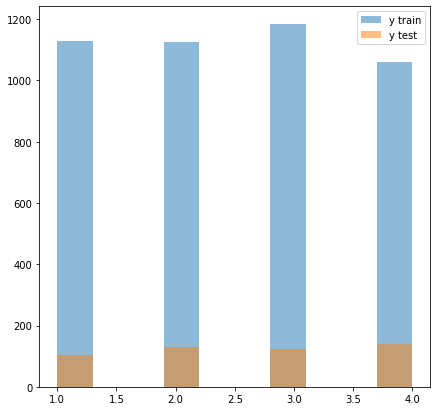

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 7)

ax.hist(y_train, alpha=0.5, label='y train')
ax.hist(y_test, alpha=0.5, label='y test')
ax.legend()